# ClickRate Sites Comparison (Python) — Snapping shrimp clicks/sec

This notebook compares **click rate (clicks/sec)** across multiple sites.

It mirrors the structure of `NDSI_Sites_Comparison_Python.ipynb`:
- Config: define `dirs_sites`, date range, sampling controls
- Run: scan WAVs (recursive), filter/select files, compute clicks/sec per segment
- Plots: facet time-series (one panel per site) and summary tables


In [ ]:
# @title Imports

from pathlib import Path
import os
import re
import sys
import time
from typing import Optional

import numpy as np
import pandas as pd

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from scipy.signal import hilbert, butter, filtfilt

try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = None

try:
    import soundfile as sf
except Exception:
    sf = None

try:
    import librosa
except Exception:
    librosa = None


In [ ]:
# COLAB ONLY: stage audio from Drive to local disk

import subprocess
from pathlib import Path

try:
    from google.colab import drive  # type: ignore

    drive.mount('/content/drive')

    # Drive paths (source of truth)
    dirs_sites_drive = {
        "San Antonio 38": Path("/content/drive/Shareddrives/MAR FUTURA/Hydrophones/San Antonio/12-11-25/38"),
        "Ventanas 36": Path("/content/drive/Shareddrives/MAR FUTURA/Hydrophones/Ventanas/07-11-25/36"),
        "Zapallar 34": Path("/content/drive/Shareddrives/MAR FUTURA/Hydrophones/Zapallar/07-11-25/34"),
        "Las Cruces 26": Path("/content/drive/Shareddrives/MAR FUTURA/Hydrophones/LasCruces/12-11-25/26"),
        "Matanzas 32": Path("/content/drive/Shareddrives/MAR FUTURA/Hydrophones/Matanzas/13-11-25/32"),
    }
    output_dir = Path("/content/drive/Shareddrives/MAR FUTURA/Hydrophones/ClickRateResults")

    run_root = "/content/run_clickrate_sites"
    local_root = Path(run_root) / "sites"
    local_root.mkdir(parents=True, exist_ok=True)

    dirs_sites = {}
    for label, src in dirs_sites_drive.items():
        dst = local_root / label.replace("/", "_")
        dst.mkdir(parents=True, exist_ok=True)
        subprocess.run(
            [
                'rsync', '-a', '--info=progress2', '--prune-empty-dirs',
                '--include=*/', '--include=*.wav', '--include=*.WAV', '--exclude=*',
                str(src).rstrip('/') + '/',
                str(dst).rstrip('/') + '/',
            ],
            check=True,
        )
        dirs_sites[label] = dst

    output_dir.mkdir(parents=True, exist_ok=True)

    print('Staged sites to:', local_root)
    print('Outputs will be written to:', output_dir)

except Exception:
    # Not running in Colab
    pass


In [ ]:
# @title Configuration (LOCAL ONLY)

from pathlib import Path

# Set these only if you're running locally.
dirs_sites = {
    "San Antonio 38": Path("/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/San Antonio/12-11-25/38"),
    "Ventanas 36": Path("/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/Ventanas/07-11-25/36"),
    "Zapallar 34": Path("/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/Zapallar/07-11-25/34"),
    "Las Cruces 26": Path("/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/LasCruces/12-11-25/26"),
    "Matanzas 32": Path("/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/Matanzas/13-11-25/32"),
}
output_dir = Path("/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/ClickRateResults")

print('dirs_sites:', {k: str(v) for k, v in dirs_sites.items()})
print('output_dir:', output_dir)


PosixPath('/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/ClickRateResults')

In [ ]:
# @title Configuration (COMMON - ALWAYS RUN)

# -----------------------------
# USER SETTINGS
# -----------------------------

segment_sec = 60

hp_cutoff_hz = 2000
hp_order = 4
env_thresh_factor = 2.5
der_thresh_factor = 2.5
t_min = 0.03

tz = "UTC"

files_per_hour = 2
files_per_folder = None

start_date = pd.Timestamp("2025-11-21 00:00:00", tz=tz)
end_date = pd.Timestamp("2025-11-29 23:59:59", tz=tz)

# -----------------------------
# VALIDATE PATHS
# -----------------------------

_required = ["dirs_sites", "output_dir"]
_missing = [k for k in _required if k not in globals() or not globals()[k]]
if _missing:
    raise RuntimeError(
        "Missing required variables from the Colab-only or Local-only config cell: " + ", ".join(_missing)
    )

output_dir = Path(output_dir)
output_dir.mkdir(parents=True, exist_ok=True)

_dirs_sites = {}
for k, v in dict(dirs_sites).items():
    _dirs_sites[str(k)] = Path(v)
dirs_sites = _dirs_sites

print('dirs_sites:', {k: str(v) for k, v in dirs_sites.items()})
print('output_dir:', output_dir)
print('segment_sec:', segment_sec)
print('hp_cutoff_hz:', hp_cutoff_hz)
print('env_thresh_factor:', env_thresh_factor)
print('der_thresh_factor:', der_thresh_factor)
print('t_min:', t_min)
print('files_per_hour:', files_per_hour)
print('files_per_folder:', files_per_folder)
print('start_date:', start_date)
print('end_date:', end_date)


In [2]:
# RUN (everything)
sns.set_theme(style="whitegrid")

# Filenames expected: 20251121_180400.WAV or ST_1234_20251121_180400.WAV
_DT_RE = re.compile(r"^(?:ST_\d+_)?(\d{8}_\d{6})\.WAV$", re.IGNORECASE)


def extract_datetime(path: Path, tz: str = "UTC") -> pd.Timestamp:
    m = _DT_RE.match(path.name)
    if not m:
        raise ValueError(f"Filename does not match expected pattern: {path.name}")
    dt = pd.to_datetime(m.group(1), format="%Y%m%d_%H%M%S", utc=True)
    if tz.upper() == "UTC":
        return dt
    return dt.tz_convert(tz)


def read_wav_mono(path: Path, target_sr: Optional[int] = None):
    if sf is not None:
        audio, sr = sf.read(str(path), always_2d=True)
        audio = audio.mean(axis=1)
        if target_sr is not None and target_sr != sr:
            if librosa is None:
                raise RuntimeError("Resampling requested but librosa is not available")
            audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
            sr = target_sr
        return audio.astype(np.float32, copy=False), int(sr)

    if librosa is None:
        raise RuntimeError("Neither soundfile nor librosa is not available to read WAV files")

    audio, sr = librosa.load(str(path), sr=target_sr, mono=True)
    return audio.astype(np.float32, copy=False), int(sr)


def highpass_filter(sig: np.ndarray, sr: int, cutoff: float = 2000.0, order: int = 4) -> np.ndarray:
    nyq = 0.5 * sr
    norm_cutoff = float(cutoff) / nyq
    b, a = butter(order, norm_cutoff, btype="high")
    return filtfilt(b, a, sig)


def detect_click_count(audio: np.ndarray, sr: int, env_factor: float, der_factor: float, t_min: float, cutoff_hz: float, hp_order: int) -> int:
    if audio.size == 0 or sr <= 0:
        return 0

    audio = audio.astype(np.float32, copy=False)
    max_amp = float(np.max(np.abs(audio))) if audio.size else 0.0
    audio = audio / (max_amp + 1e-10)
    sig = audio - float(np.mean(audio))

    sig = highpass_filter(sig, sr, cutoff=cutoff_hz, order=hp_order)

    env = np.abs(hilbert(sig))
    denv = np.diff(env, prepend=env[0])

    e_th = float(env.mean() + env.std() * env_factor)
    d_th = float(denv.mean() + denv.std() * der_factor)

    min_samp = int(round(t_min * sr))
    if min_samp < 1:
        min_samp = 1

    n_clicks = 0
    last_idx = -min_samp
    for i in range(denv.size):
        if env[i] > e_th and denv[i] > d_th and (i - last_idx) >= min_samp:
            n_clicks += 1
            last_idx = i
    return int(n_clicks)


def evenly_spaced_indices(n: int, k: int) -> np.ndarray:
    if k <= 0:
        return np.array([], dtype=int)
    if n <= k:
        return np.arange(n, dtype=int)
    idx = np.round((np.arange(1, k + 1) * (n + 1)) / (k + 1)).astype(int) - 1
    idx = np.clip(idx, 0, n - 1)
    return np.unique(idx)


def select_files(files):
    rows = []
    parse_fail = 0

    for p in files:
        try:
            dt = extract_datetime(p, tz=tz)
        except Exception:
            parse_fail += 1
            continue

        if start_date is not None and dt < (start_date - pd.Timedelta(seconds=segment_sec)):
            continue
        if end_date is not None and dt > end_date:
            continue

        rows.append((p, dt))

    if parse_fail > 0:
        print(f"Skipped {parse_fail} files due to filename parse mismatch")

    if not rows:
        return []

    df = pd.DataFrame(rows, columns=["path", "dt"]).sort_values("dt")

    if files_per_hour is not None:
        df["hour"] = df["dt"].dt.floor("h")
        picked = []
        for _, g in df.groupby("hour", sort=True):
            g = g.sort_values("dt")
            idx = evenly_spaced_indices(len(g), int(files_per_hour))
            picked.append(g.iloc[idx])
        df = pd.concat(picked, ignore_index=True)

    paths = df["path"].tolist()
    if files_per_folder is not None:
        paths = paths[: int(files_per_folder)]
    return paths


def _scan_wavs_with_progress(directory: Path, label: str):
    directory = Path(directory)
    wavs = []

    t0 = time.time()
    last = t0
    scanned_dirs = 0

    print(f"Scanning for WAV files in: {directory}")

    for root, _, files in os.walk(directory):
        scanned_dirs += 1
        for name in files:
            if name.lower().endswith(".wav"):
                wavs.append(Path(root) / name)

        now = time.time()
        if now - last >= 1.0:
            elapsed = now - t0
            print(f"{label}: scanned {scanned_dirs} folders, found {len(wavs)} wavs so far ({elapsed:.0f}s)")
            last = now

    return sorted(wavs)


def process_site_click_rate(directory: Path, label: str) -> pd.DataFrame:
    wavs = _scan_wavs_with_progress(directory, label)
    print(f"Found {len(wavs)} files in {label} (recursive)")

    wavs = select_files(wavs)
    print(f"Using {len(wavs)} files in {label} after filters")

    out_rows = []
    n = len(wavs)

    iterator = wavs
    use_tqdm = tqdm is not None and n > 0
    if use_tqdm:
        iterator = tqdm(wavs, desc=f"{label}: files", unit="file")

    for i, fp in enumerate(iterator, start=1):
        if not use_tqdm:
            pct = 100.0 * i / max(1, n)
            sys.stdout.write(f"\r{label}: {i}/{n} files ({pct:5.1f}%)")
            sys.stdout.flush()

        try:
            start_dt = extract_datetime(fp, tz=tz)
        except Exception:
            continue

        try:
            audio, sr = read_wav_mono(fp, target_sr=None)
        except Exception as e:
            print(f"Skipping unreadable file: {fp} ({e})")
            continue

        if audio.size == 0 or sr <= 0:
            continue

        dur_sec = audio.size / sr
        seg_len = min(float(segment_sec), float(dur_sec))
        if not np.isfinite(seg_len) or seg_len <= 0:
            continue

        max_start = max(0.0, float(dur_sec) - seg_len)
        starts = np.arange(0.0, max_start + 1e-9, seg_len)

        for st in starts:
            segment_time = start_dt + pd.to_timedelta(float(st), unit="s")
            if start_date is not None and segment_time < start_date:
                continue
            if end_date is not None and segment_time > end_date:
                break

            i0 = int(round(float(st) * sr))
            i1 = int(round((float(st) + seg_len) * sr))
            seg = audio[i0:i1]
            if seg.size == 0:
                continue

            n_clicks = detect_click_count(
                audio=seg,
                sr=sr,
                env_factor=env_thresh_factor,
                der_factor=der_thresh_factor,
                t_min=t_min,
                cutoff_hz=hp_cutoff_hz,
                hp_order=hp_order,
            )
            cps = float(n_clicks) / float(seg_len)

            out_rows.append(
                {
                    "Site": label,
                    "Time": segment_time,
                    "Clicks": int(n_clicks),
                    "Segment_Sec": float(seg_len),
                    "Clicks_Per_Sec": float(cps),
                }
            )

        if not use_tqdm and i % 25 == 0:
            print(f"{label}: processed {i}/{len(wavs)} files")

    if not use_tqdm:
        sys.stdout.write("\n")
        sys.stdout.flush()

    return pd.DataFrame(out_rows)


all_results_list = []
for label, directory in dirs_sites.items():
    if not directory.exists():
        print(f"WARN: missing directory for {label}: {directory}")
        continue
    all_results_list.append(process_site_click_rate(directory, label))

all_results = (
    pd.concat(all_results_list, ignore_index=True)
    if len(all_results_list) > 0
    else pd.DataFrame(columns=["Site", "Time", "Clicks", "Segment_Sec", "Clicks_Per_Sec"])
)

if all_results.empty:
    raise RuntimeError("No results produced. Check directory paths, filename patterns, and date range.")


def _date_tag(ts: pd.Timestamp) -> str:
    if ts is None:
        return "NA"
    return pd.Timestamp(ts).strftime("%Y%m%d")


start_tag = _date_tag(start_date) if start_date is not None else "NA"
end_tag = _date_tag(end_date) if end_date is not None else "NA"
date_tag = f"{start_tag}-{end_tag}" if start_date is not None and end_date is not None else "alltime"

out_csv = output_dir / f"clickrate_casestudies_{date_tag}.csv"
all_results.to_csv(out_csv, index=False)
print("Saved to:", out_csv)

summary_stats = (
    all_results.groupby("Site", as_index=False)
    .agg(
        Segments=("Clicks_Per_Sec", "size"),
        Mean_Clicks_Per_Sec=("Clicks_Per_Sec", "mean"),
        SD_Clicks_Per_Sec=("Clicks_Per_Sec", "std"),
        Mean_Clicks=("Clicks", "mean"),
        SD_Clicks=("Clicks", "std"),
    )
    .sort_values("Site")
)
print(summary_stats)


Scanning for WAV files in: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/San Antonio/12-11-25/38
Found 15612 files in San Antonio 38 (recursive)
Using 432 files in San Antonio 38 after filters
San Antonio 38: 25/432 files (  5.8%)San Antonio 38: processed 25/432 files
San Antonio 38: 50/432 files ( 11.6%)San Antonio 38: processed 50/432 files
San Antonio 38: 75/432 files ( 17.4%)San Antonio 38: processed 75/432 files
San Antonio 38: 100/432 files ( 23.1%)San Antonio 38: processed 100/432 files
San Antonio 38: 125/432 files ( 28.9%)San Antonio 38: processed 125/432 files
San Antonio 38: 150/432 files ( 34.7%)San Antonio 38: processed 150/432 files
San Antonio 38: 175/432 files ( 40.5%)San Antonio 38: processed 175/432 files
San Antonio 38: 200/432 files ( 46.3%)San Antonio 38: processed 200/432 files
San Antonio 38: 225/432 files ( 52.1%)San Antonio 38: processed 225/432 files
San Antonio 38: 250/432 files ( 57.9%)San

/var/folders/98/p03nljld21n2xrkp6cmfsv6w0000gn/T/ipykernel_72260/937537643.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  sm = s.rolling(SMOOTH_ROLLING_TIME, min_periods=int(SMOOTH_MIN_PERIODS)).mean()
/var/folders/98/p03nljld21n2xrkp6cmfsv6w0000gn/T/ipykernel_72260/937537643.py:64: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("Site", observed=True, sort=False).apply(_smooth_one).reset_index(level=0, drop=True)


Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/ClickRateResults/Graphs/clickrate_casestudies_20251121-20251129_clicks_per_sec.png


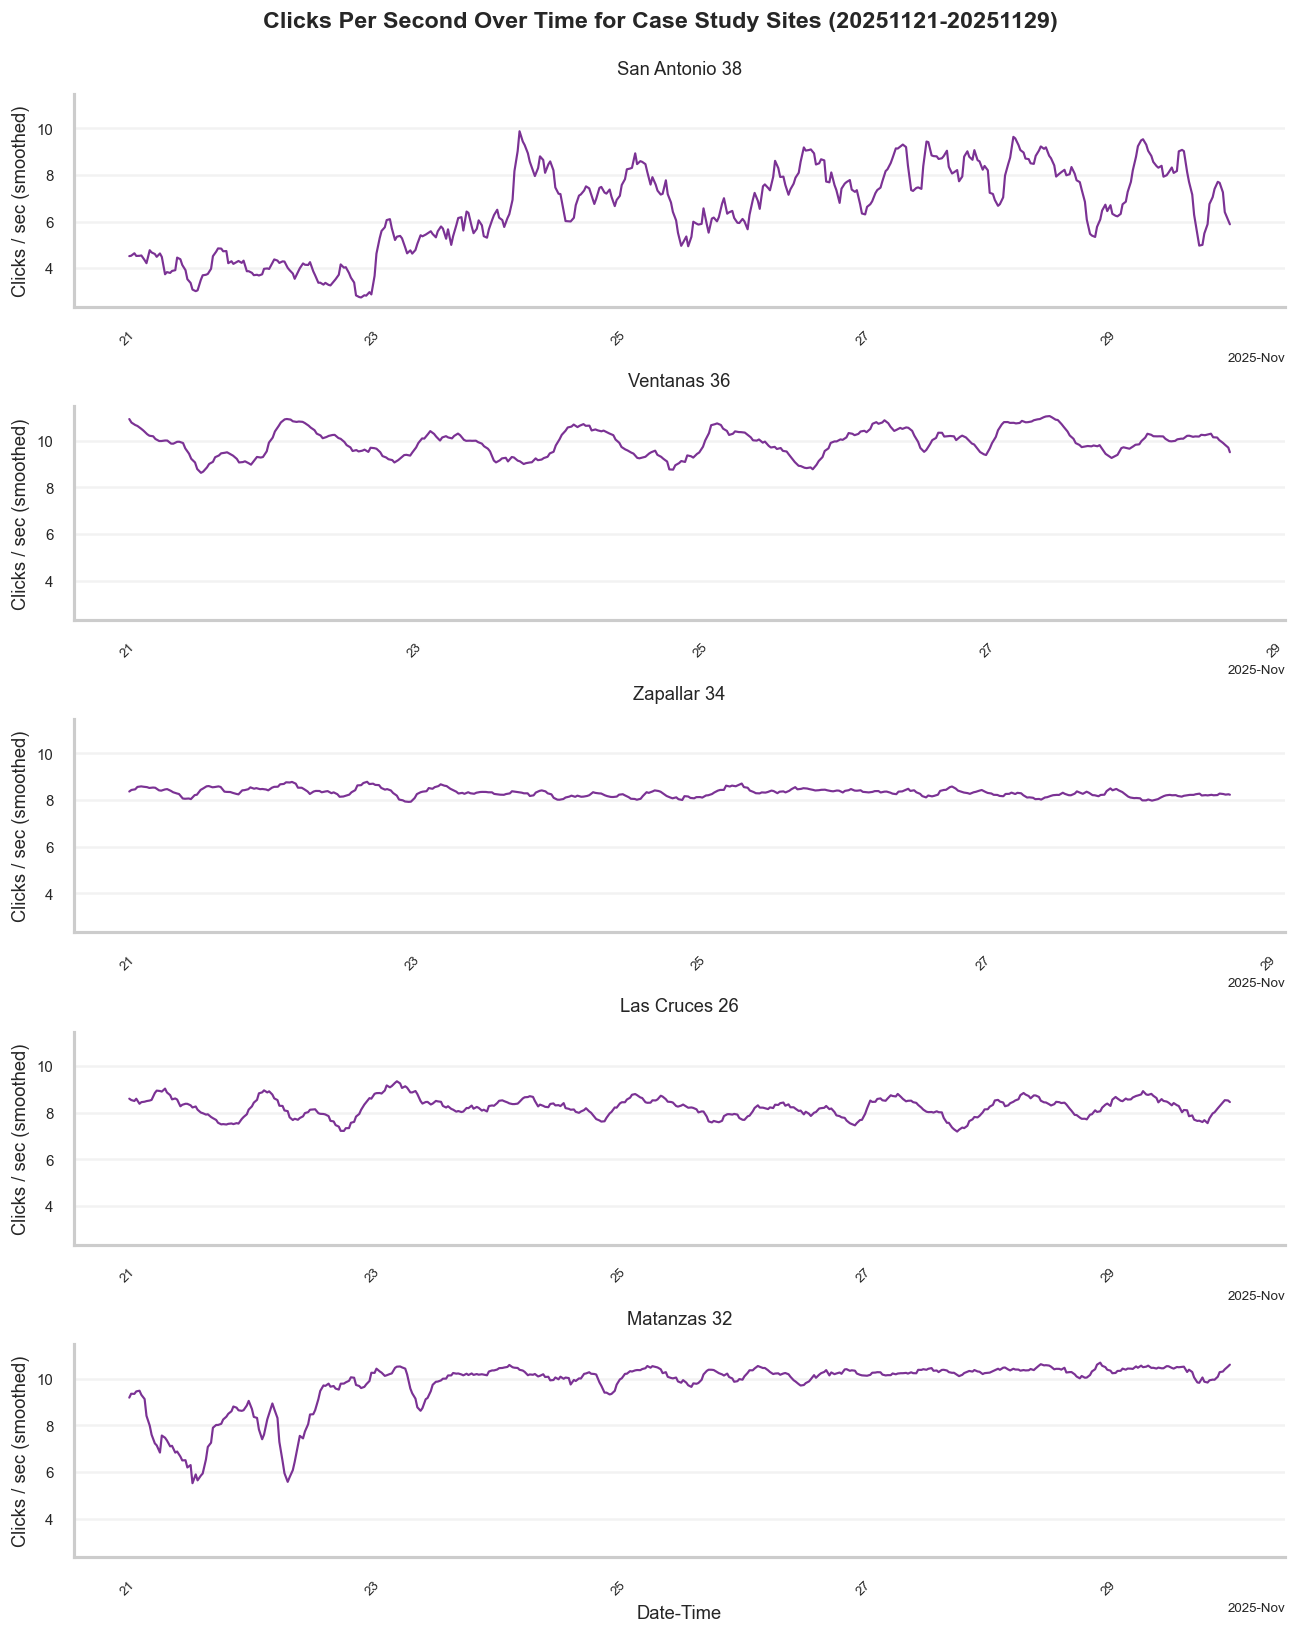

Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/ClickRateResults/Graphs/clickrate_casestudies_20251121-20251129_clicks_per_sec_all_sites.png


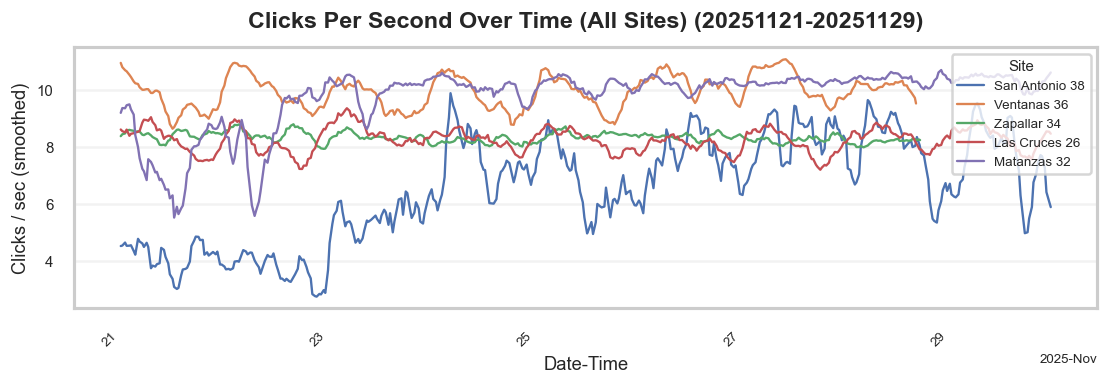

Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/ClickRateResults/Graphs/clickrate_casestudies_20251121-20251129_summary_stats.csv


In [6]:
# PLOTS (save to disk)

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update(
    {
        "figure.dpi": 120,
        "savefig.dpi": 200,
        "axes.titlepad": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 11,
        "xtick.labelsize": 8,
        "ytick.labelsize": 9,
        "grid.alpha": 0.25,
    }
)

SHOW_PLOTS_INLINE = True

SMOOTH_ROLLING_TIME = "3H"
SMOOTH_ROLLING_POINTS = None
SMOOTH_MIN_PERIODS = 1

# Only use outputs from the analysis you just ran.
if "all_results" in globals() and isinstance(all_results, pd.DataFrame) and not all_results.empty:
    plot_data = all_results.copy()
elif "out_csv" in globals() and Path(out_csv).exists():
    plot_data = pd.read_csv(out_csv)
else:
    raise RuntimeError("No plot input found. Run the analysis cell first (it should create all_results and out_csv).")

required_cols = {"Site", "Time", "Clicks_Per_Sec"}
missing_cols = required_cols - set(plot_data.columns)
if missing_cols:
    raise RuntimeError(f"Missing columns for plotting: {sorted(missing_cols)}")

plot_data["Time"] = pd.to_datetime(plot_data["Time"], utc=True, errors="coerce")
if plot_data["Time"].isna().any():
    plot_data["Time"] = pd.to_datetime(plot_data["Time"], errors="coerce")
if plot_data["Time"].isna().any():
    raise RuntimeError("Could not parse Time column for plotting")

site_order = list(pd.unique(plot_data["Site"].astype(str)))
plot_data["Site"] = pd.Categorical(plot_data["Site"].astype(str), categories=site_order, ordered=True)
plot_data = plot_data.sort_values(["Site", "Time"])

graphs_dir = Path(output_dir) / "Graphs"
graphs_dir.mkdir(parents=True, exist_ok=True)
base = Path(out_csv).stem


if SMOOTH_ROLLING_TIME is not None and SMOOTH_ROLLING_POINTS is not None:
    raise RuntimeError("Set only one of SMOOTH_ROLLING_TIME or SMOOTH_ROLLING_POINTS")


def _smooth_clicks_per_sec(df: pd.DataFrame) -> pd.Series:
    def _smooth_one(g: pd.DataFrame) -> pd.Series:
        s = g.set_index("Time")["Clicks_Per_Sec"].sort_index()
        if SMOOTH_ROLLING_TIME is not None:
            sm = s.rolling(SMOOTH_ROLLING_TIME, min_periods=int(SMOOTH_MIN_PERIODS)).mean()
        else:
            sm = s.rolling(int(SMOOTH_ROLLING_POINTS), min_periods=int(SMOOTH_MIN_PERIODS)).mean()
        return pd.Series(sm.values, index=g.sort_values("Time").index)

    return df.groupby("Site", observed=True, sort=False).apply(_smooth_one).reset_index(level=0, drop=True)


use_smoothing = (SMOOTH_ROLLING_TIME is not None) or (SMOOTH_ROLLING_POINTS is not None)
if use_smoothing:
    plot_data["Clicks_Per_Sec_Smoothed"] = _smooth_clicks_per_sec(plot_data)
    y_col = "Clicks_Per_Sec_Smoothed"
    y_label = "Clicks / sec (smoothed)"
else:
    y_col = "Clicks_Per_Sec"
    y_label = "Clicks / sec"


def _finite_min_max(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce")
    s = s[np.isfinite(s)]
    if s.empty:
        return None
    return float(s.min()), float(s.max())


def _pad_limits(lims, pad_frac: float = 0.05):
    if lims is None:
        return None
    lo, hi = lims
    if not np.isfinite(lo) or not np.isfinite(hi):
        return None
    if lo == hi:
        eps = 1e-12 if lo == 0 else abs(lo) * 0.05
        return lo - eps, hi + eps
    pad = (hi - lo) * pad_frac
    return lo - pad, hi + pad


# Use the SAME y-axis limits across all sites (same axis numbers)
cps_ylim = _pad_limits(_finite_min_max(plot_data[y_col]))


def _facet_timeseries(y_col: str, y_label: str, title: str, filename: str, ylim=None, color="#1f77b4"):
    g = sns.relplot(
        data=plot_data,
        x="Time",
        y=y_col,
        col="Site",
        col_wrap=1,
        kind="line",
        height=2.7,
        aspect=4.2,
        facet_kws=dict(sharex=False, sharey=True),
        linewidth=1.3,
        color=color,
    )
    g.set_axis_labels("Date-Time", y_label)
    g.set_titles("{col_name}")
    g.fig.suptitle(title, y=1.01, fontsize=14, fontweight="bold")

    for ax in g.axes.flat:
        locator = mdates.AutoDateLocator(minticks=3, maxticks=6)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
        ax.tick_params(axis="x", labelrotation=45)

        if ylim is not None:
            ax.set_ylim(ylim)

        ax.grid(True, axis="y")
        ax.grid(False, axis="x")

    out_path = graphs_dir / filename
    g.fig.savefig(out_path, dpi=200, bbox_inches="tight")
    print("Saved:", out_path)

    if SHOW_PLOTS_INLINE:
        display(g.fig)

    plt.close(g.fig)


_title_suffix = None
if "start_date" in globals() and "end_date" in globals() and start_date is not None and end_date is not None:
    _title_suffix = f"{start_date.strftime('%Y%m%d')}-{end_date.strftime('%Y%m%d')}"
suffix = f" ({_title_suffix})" if _title_suffix else ""

# 1) Faceted plot (one panel per site) with shared y-axis limits
_facet_timeseries(
    y_col=y_col,
    y_label=y_label,
    title=f"Clicks Per Second Over Time for Case Study Sites{suffix}",
    filename=f"{base}_clicks_per_sec.png",
    ylim=cps_ylim,
    color="#7B3294",
)

# 2) Combined plot (all sites on one axis, different colours)
fig, ax = plt.subplots(figsize=(11, 3.2))
sns.lineplot(
    data=plot_data,
    x="Time",
    y=y_col,
    hue="Site",
    linewidth=1.4,
    ax=ax,
)
ax.set_title(f"Clicks Per Second Over Time (All Sites){suffix}", fontweight="bold")
ax.set_xlabel("Date-Time")
ax.set_ylabel(y_label)

locator = mdates.AutoDateLocator(minticks=3, maxticks=6)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
fig.autofmt_xdate(rotation=45)

if cps_ylim is not None:
    ax.set_ylim(cps_ylim)

ax.grid(True, axis="y")
ax.grid(False, axis="x")
ax.legend(title="Site", loc="upper right", fontsize=8, title_fontsize=9)

out_path = graphs_dir / f"{base}_clicks_per_sec_all_sites.png"
fig.savefig(out_path, dpi=200, bbox_inches="tight")
print("Saved:", out_path)

if SHOW_PLOTS_INLINE:
    display(fig)

plt.close(fig)

# ---------- Tables ----------
summary_stats_out = (
    plot_data.groupby("Site", as_index=False, observed=True)
    .agg(
        Segments=("Clicks_Per_Sec", "size"),
        Mean_Clicks_Per_Sec=("Clicks_Per_Sec", "mean"),
        SD_Clicks_Per_Sec=("Clicks_Per_Sec", "std"),
        Mean_Clicks=("Clicks", "mean"),
        SD_Clicks=("Clicks", "std"),
    )
)

summary_path = graphs_dir / f"{base}_summary_stats.csv"
summary_stats_out.to_csv(summary_path, index=False)
print("Saved:", summary_path)


Using NDSI CSV: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/NDSIResults/ndsi_casestudies_alltime_anthro_1000-2000_bio_2000-3000.csv
Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/ClickRateResults/Graphs/clickrate_casestudies_20251121-20251129_ndsi_vs_clicks_overlay_san_antonio_38.png


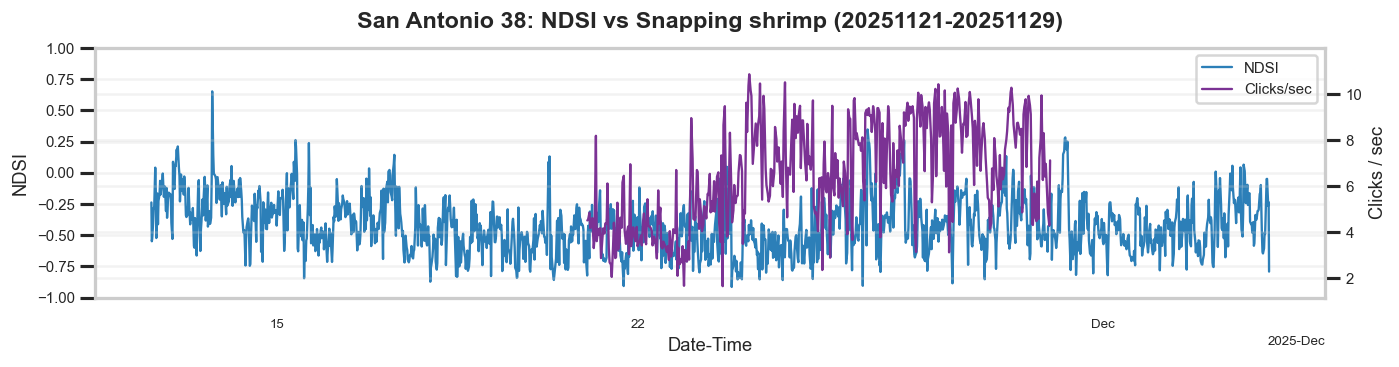

Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/ClickRateResults/Graphs/clickrate_casestudies_20251121-20251129_ndsi_vs_clicks_overlay_ventanas_36.png


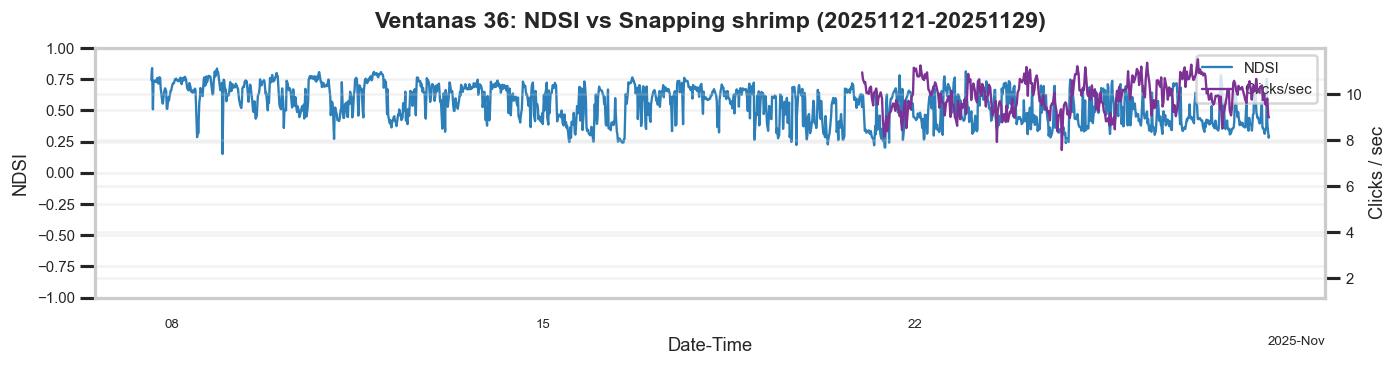

Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/ClickRateResults/Graphs/clickrate_casestudies_20251121-20251129_ndsi_vs_clicks_overlay_zapallar_34.png


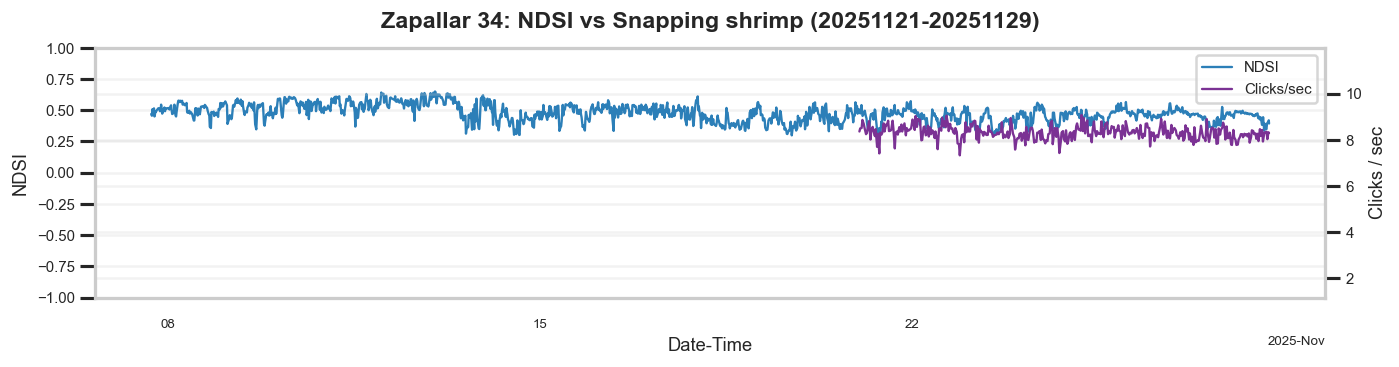

Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/ClickRateResults/Graphs/clickrate_casestudies_20251121-20251129_ndsi_vs_clicks_overlay_las_cruces_26.png


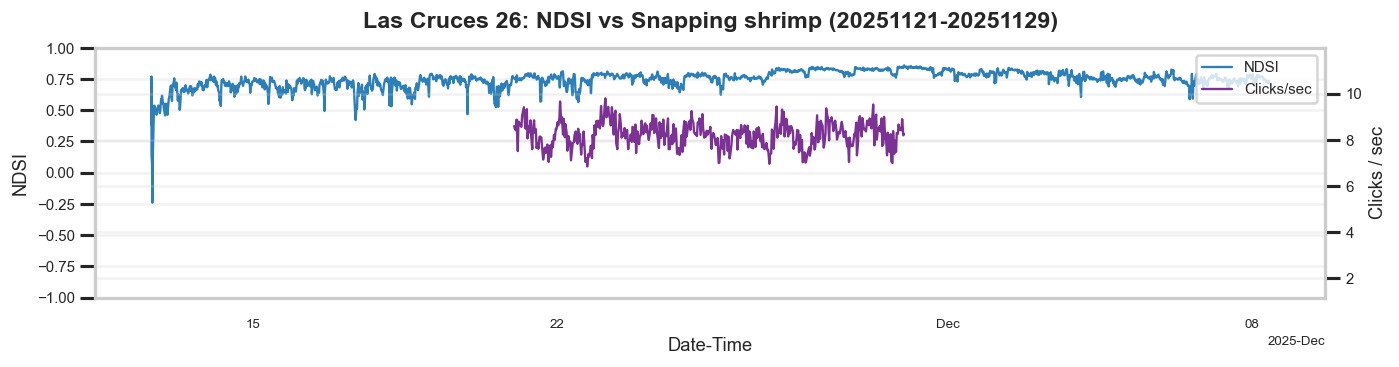

Saved: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/ClickRateResults/Graphs/clickrate_casestudies_20251121-20251129_ndsi_vs_clicks_overlay_matanzas_32.png


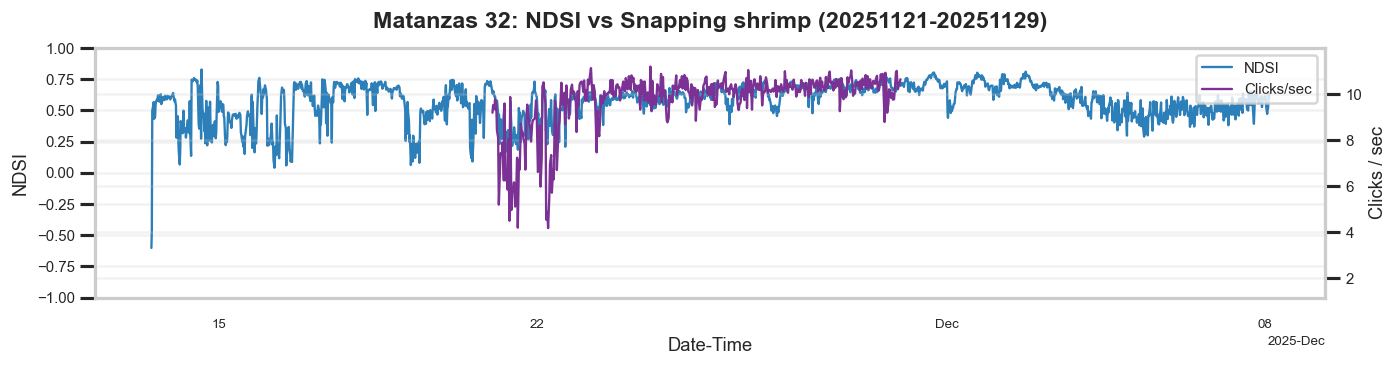

In [4]:
# NDSI vs Snapping Shrimp (per site, same graph)

from pathlib import Path

# --- Configure where to load NDSI results from ---
ndsi_results_dir = Path(
    "/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/NDSIResults"
)

# Option A (recommended): explicitly set the CSV path
ndsi_csv_path = None  # e.g. ndsi_results_dir / "ndsi_casestudies_20251121-20251129_anthro_500-2000_bio_2000-3000.csv"

# Option B: auto-pick newest NDSI case-studies CSV in the folder
if ndsi_csv_path is None:
    candidates = sorted(ndsi_results_dir.glob("ndsi_casestudies_*.csv"), key=lambda p: p.stat().st_mtime)
    if not candidates:
        raise RuntimeError(f"No NDSI casestudies CSV found in: {ndsi_results_dir}")
    ndsi_csv_path = candidates[-1]

print("Using NDSI CSV:", ndsi_csv_path)

# --- Load click-rate data from the run you just did ---
if "all_results" in globals() and isinstance(all_results, pd.DataFrame) and not all_results.empty:
    clicks_df = all_results.copy()
elif "out_csv" in globals() and Path(out_csv).exists():
    clicks_df = pd.read_csv(out_csv)
else:
    raise RuntimeError("No click-rate results found. Run the analysis cell first.")

# --- Load NDSI ---
ndsi_df = pd.read_csv(ndsi_csv_path)

# Validate columns
for col in ["Site", "Time", "NDSI"]:
    if col not in ndsi_df.columns:
        raise RuntimeError(f"NDSI CSV missing required column: {col}")
for col in ["Site", "Time", "Clicks_Per_Sec"]:
    if col not in clicks_df.columns:
        raise RuntimeError(f"Click-rate results missing required column: {col}")

# Parse times
clicks_df["Time"] = pd.to_datetime(clicks_df["Time"], utc=True, errors="coerce")
ndsi_df["Time"] = pd.to_datetime(ndsi_df["Time"], utc=True, errors="coerce")
clicks_df = clicks_df.dropna(subset=["Time"]).copy()
ndsi_df = ndsi_df.dropna(subset=["Time"]).copy()

# Keep only overlapping sites
click_sites = set(clicks_df["Site"].astype(str))
ndsi_sites = set(ndsi_df["Site"].astype(str))
common_sites = [s for s in site_order if s in click_sites and s in ndsi_sites]

if not common_sites:
    raise RuntimeError(
        "No overlapping sites between click-rate results and NDSI CSV. "
        "Check site names match exactly in both tables."
    )

# Optional alignment: resample both time series
resample_rule = None  # e.g. "1H"

# Site -> stable color
palette = dict(zip(common_sites, sns.color_palette("tab10", n_colors=len(common_sites))))

# Helper to make site tags safe for filenames
_site_safe_re = re.compile(r"[^A-Za-z0-9]+")

def _site_tag(site: str) -> str:
    return _site_safe_re.sub("_", site.strip().lower()).strip("_")


def _smooth_clicks_one_site(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values("Time").copy()

    smooth_time = globals().get("SMOOTH_ROLLING_TIME", None)
    smooth_pts = globals().get("SMOOTH_ROLLING_POINTS", None)
    smooth_min = globals().get("SMOOTH_MIN_PERIODS", 1)

    if smooth_time is not None and smooth_pts is not None:
        raise RuntimeError("Set only one of SMOOTH_ROLLING_TIME or SMOOTH_ROLLING_POINTS")

    if smooth_time is None and smooth_pts is None:
        return df

    s = df.set_index("Time")["Clicks_Per_Sec"]
    if smooth_time is not None:
        sm = s.rolling(smooth_time, min_periods=int(smooth_min)).mean()
    else:
        sm = s.rolling(int(smooth_pts), min_periods=int(smooth_min)).mean()

    df["Clicks_Per_Sec"] = sm.values
    return df


# Global axis limits
ndsi_ylim = (-1.0, 1.0)
shrimp_ylim = cps_ylim if ("cps_ylim" in globals() and cps_ylim is not None) else None

for site in common_sites:
    ndsi_site = ndsi_df[ndsi_df["Site"].astype(str) == site].copy()
    clicks_site = clicks_df[clicks_df["Site"].astype(str) == site].copy()
    clicks_site = _smooth_clicks_one_site(clicks_site)

    if resample_rule is not None:
        ndsi_plot = (
            ndsi_site.set_index("Time")["NDSI"]
            .resample(resample_rule)
            .mean()
            .dropna()
            .reset_index()
        )
        clicks_plot = (
            clicks_site.set_index("Time")["Clicks_Per_Sec"]
            .resample(resample_rule)
            .mean()
            .dropna()
            .reset_index()
        )
    else:
        ndsi_plot = ndsi_site[["Time", "NDSI"]].dropna()
        clicks_plot = clicks_site[["Time", "Clicks_Per_Sec"]].dropna()

    fig, ax = plt.subplots(figsize=(12, 3.4))
    ax2 = ax.twinx()

    # NDSI (left axis)
    ln1 = ax.plot(
        ndsi_plot["Time"],
        ndsi_plot["NDSI"],
        color="#2C7FB8",
        linewidth=1.4,
        label="NDSI",
    )
    ax.set_ylabel("NDSI")
    ax.set_ylim(ndsi_ylim)

    # Shrimp click rate (right axis)
    ln2 = ax2.plot(
        clicks_plot["Time"],
        clicks_plot["Clicks_Per_Sec"],
        color="#7B3294",
        linewidth=1.4,
        label="Clicks/sec",
    )
    ax2.set_ylabel("Clicks / sec")
    if shrimp_ylim is not None:
        ax2.set_ylim(shrimp_ylim)

    # Shared x formatting
    ax.set_xlabel("Date-Time")
    locator = mdates.AutoDateLocator(minticks=3, maxticks=6)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

    ax.grid(True, axis="y")
    ax.grid(False, axis="x")

    _title_suffix = None
    if "start_date" in globals() and "end_date" in globals() and start_date is not None and end_date is not None:
        _title_suffix = f"{start_date.strftime('%Y%m%d')}-{end_date.strftime('%Y%m%d')}"
    suffix = f" ({_title_suffix})" if _title_suffix else ""

    ax.set_title(f"{site}: NDSI vs Snapping shrimp{suffix}", fontweight="bold")

    # One combined legend
    lines = ln1 + ln2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc="upper right", fontsize=9)

    plt.tight_layout()

    out_path = graphs_dir / f"{base}_ndsi_vs_clicks_overlay_{_site_tag(site)}.png"
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    print("Saved:", out_path)

    if SHOW_PLOTS_INLINE:
        display(fig)

    plt.close(fig)
